In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sn
import glob
import os
import sys

import plotly.express as px
import seaborn as sns

import networkx as nx

import utm

# Definir carpetas y archivos a utilizar

In [5]:
root_dir = os.path.dirname(os.getcwd())

# Directorios principales
ProcesamientoDatos_dir = os.path.join(root_dir, 'a. Procesamiento de datos')
Estudios_dir = os.path.join(root_dir, 'b. Estudio Correlacion y Sistema')
Simulacion_dir = os.path.join(root_dir, 'c. Simulacion sistema')

# Datos de entrada
Datos_dir = os.path.join(os.path.dirname(root_dir), '1. Datos de entrada')
GenData_dir = os.path.join(Datos_dir, 'Generacion')
datosCEN_dir = os.path.join(GenData_dir, 'Datos_CEN')
CEN_dir = os.path.join(Datos_dir, 'CEN')

# Datos de salida
Output_dir = os.path.join(ProcesamientoDatos_dir, 'Output')

# Archivos de trabajo
IPLP_file = os.path.join(CEN_dir, 'IPLP20240501_mensual.xlsm')
BarrasRepresentativas_file = os.path.join(CEN_dir, 'BarrasRepresentativas.xlsx')

In [6]:
def readIPLP(file):
    df_Lineas = pd.read_excel(file, sheet_name='Líneas', header=4)
    df_Lineas.dropna(subset=['Nº'], inplace=True)

    df_LineasParametros = df_Lineas.iloc[:, 0:14]
    df_LineasLargo = df_Lineas.iloc[:, 15:22]

    df_Barras = pd.read_excel(file, sheet_name='Barras', header=4)
    df_Barras.dropna(subset=['Nº'], inplace=True)
    # drop all columns with all NaN values
    df_Barras = df_Barras.dropna(axis=1, how='all')
    return df_LineasParametros, df_LineasLargo, df_Barras

df_LineasParametros, df_LineasLargo, df_Barras = readIPLP(IPLP_file)

df_BarrasRepresentativas_Asig = pd.read_excel(BarrasRepresentativas_file, sheet_name='Asignacion', header=1, usecols='B:G')

for i, row in df_BarrasRepresentativas_Asig.iterrows():
    Este = float(row['Coordenada Este'])
    Norte = float(row['Coordenada Norte'])
    ZonaHuso = row['Huso']
    Zona,Huso = int(ZonaHuso[:2]),ZonaHuso[2:].strip()
    lat, lon = utm.to_latlon(Este, Norte, Zona, Huso)
    df_BarrasRepresentativas_Asig.loc[i, 'Latitud'] = lat
    df_BarrasRepresentativas_Asig.loc[i, 'Longitud'] = lon
df_BarrasRepresentativas_Asig.drop(columns=['Coordenada Este', 'Coordenada Norte', 'Huso'], inplace=True)

df_LineasRepresentativas = pd.read_excel(BarrasRepresentativas_file, sheet_name='Parametros', header=3, usecols='B:H')

In [7]:
def buildGraph(df_LineasParametros, df_LineasLargo):
    G = nx.Graph()
    for i in range(len(df_LineasParametros)):
        line = df_LineasParametros.iloc[i]
        lineL = df_LineasLargo.iloc[i]
        BarraA = lineL['Barra A.1']
        BarraB = lineL['Barra B.1']
        Largo = lineL['LARGO']
        Nombre = line['Nombre A->B']
        G.add_edge(BarraA, BarraB, Largo=Largo, Nombre=Nombre)
    return G

def FindLenght(G, BarraA, BarraB):
    return nx.shortest_path_length(G, BarraA, BarraB, weight='Largo')

def FindShortestPath(G, Barra, df_BarrasRepresentativas_Asig):
    BarrasRepresentativas = df_BarrasRepresentativas_Asig['Barras IPLP'].values
    # Delete NaN values
    BarrasRepresentativas = BarrasRepresentativas[~pd.isnull(BarrasRepresentativas)]
    dist = []
    for BarraRep in BarrasRepresentativas:
        dist.append(FindLenght(G, Barra, BarraRep))
    return BarrasRepresentativas[np.argmin(dist)]

def AsignarBarraRepresentativa(G, df_BarrasRepresentativas_Asig, df_Barras):
    for idx,row in df_Barras.iterrows():
        Barra = row['BARRA']
        BarraRepr = FindShortestPath(G, Barra, df_BarrasRepresentativas_Asig)
        df_Barras.loc[idx, 'BarraRepresentativa'] = BarraRepr
    return df_Barras

G = buildGraph(df_LineasParametros, df_LineasLargo)
df_Barras = AsignarBarraRepresentativa(G, df_BarrasRepresentativas_Asig, df_Barras)

In [8]:
df_Barras

,Nº,BARRA,BarraRepresentativa
0,1.0,AltoNorte110,Kimal220
1,2.0,Andes220,Andes220
2,3.0,Andes345,Andes220
3,4.0,Angamos220,LosChangos220
4,5.0,Antofagasta110,Kimal220
...,...,...,...
231,232.0,Farellon220,LosChangos220
232,233.0,Itahue220,Ancoa500
233,234.0,SantaIsabel220,Ancoa500
234,235.0,Maule220,Ancoa500


In [9]:
df_Barras

,Nº,BARRA,BarraRepresentativa
0,1.0,AltoNorte110,Kimal220
1,2.0,Andes220,Andes220
2,3.0,Andes345,Andes220
3,4.0,Angamos220,LosChangos220
4,5.0,Antofagasta110,Kimal220
...,...,...,...
231,232.0,Farellon220,LosChangos220
232,233.0,Itahue220,Ancoa500
233,234.0,SantaIsabel220,Ancoa500
234,235.0,Maule220,Ancoa500


In [10]:
def CrearBarrasRepresentativas(df_BarrasRepresentativas_Asig_input):
    df_BarrasRepresentativas = pd.DataFrame({'ID':range(len(df_BarrasRepresentativas_Asig_input['Nombre Reducido'].unique())),'Barra': df_BarrasRepresentativas_Asig_input['Nombre Reducido'].unique()})

    for idx,row in df_BarrasRepresentativas.iterrows():
        Barra = row['Barra']
        Barra_IPLP = df_BarrasRepresentativas_Asig_input[df_BarrasRepresentativas_Asig_input['Nombre Reducido'] == Barra]['Barras IPLP'].values[0]
        if Barra == "TalTal220":
            Barra_IPLP = "Paposo220"
        Lat = df_BarrasRepresentativas_Asig_input[df_BarrasRepresentativas_Asig_input['Nombre Reducido'] == Barra]['Latitud'].values[0]
        Long = df_BarrasRepresentativas_Asig_input[df_BarrasRepresentativas_Asig_input['Nombre Reducido'] == Barra]['Longitud'].values[0]
        Voltaje = int(Barra[-3:])
        
        df_BarrasRepresentativas.loc[idx, 'Latitud'] = Lat
        df_BarrasRepresentativas.loc[idx, 'Longitud'] = Long
        df_BarrasRepresentativas.loc[idx, 'Voltaje'] = Voltaje

    return df_BarrasRepresentativas

df_BarrasRepresentativas = CrearBarrasRepresentativas(df_BarrasRepresentativas_Asig)

In [11]:
def CrearSistemaReducido(df_LineasRepresentativas, df_BarrasRepresentativas_Asig_input, df_BarrasRepresentativas):
    # Create a dictionary with the representative bars
    df_BarrasRepresentativas_Asig = df_BarrasRepresentativas_Asig_input.copy()
    # set all the 'Barras Estudio Almacenamiento Energia' as lowercase
    df_BarrasRepresentativas_Asig['Barras Estudio Almacenamiento Energia'] = df_BarrasRepresentativas_Asig['Barras Estudio Almacenamiento Energia'].str.lower()
    # Set the "TalTal 220 opt" to Taltal220
    df_BarrasRepresentativas_Asig.loc[df_BarrasRepresentativas_Asig['Barras Estudio Almacenamiento Energia'] == 'taltal 220 opt', 'Nombre Reducido'] = 'TalTal220'
    dict_BarrasRepresentativas = df_BarrasRepresentativas_Asig.set_index('Barras Estudio Almacenamiento Energia').to_dict()['Nombre Reducido']
    dfs_lineas = []
    for idx,row in df_LineasRepresentativas.iterrows():
        Nodo_from = dict_BarrasRepresentativas[row['Nodo A'].lower()]
        Nodo_to = dict_BarrasRepresentativas[row['Nodo B'].lower()]
        idx_linea = idx
        Nombre_Linea = f"{Nodo_from} -> {Nodo_to}"
        Idx_from = df_BarrasRepresentativas[df_BarrasRepresentativas['Barra'] == Nodo_from].index[0]
        Idx_to = df_BarrasRepresentativas[df_BarrasRepresentativas['Barra'] == Nodo_to].index[0]
        Voltaje = row['Tensión']
        Resistencia = row['Resistencia [pu]']
        Reactancia = row['Reactancia [pu]']
        CapMax = row['Capacidad Máxima N-1 [MW]']
        dfs_lineas.append([idx_linea, Nombre_Linea, Idx_from, Idx_to, Voltaje, Resistencia, Reactancia, CapMax])
    df_LineasRepresentativas = pd.DataFrame(dfs_lineas, columns=['ID', 'Nombre', 'From', 'To', 'Voltaje', 'Resistencia', 'Reactancia', 'CapacidadMax'])
    df_LineasRepresentativas.fillna(0, inplace=True)

    # Delete the last 3 rows
    df_LineasRepresentativas = df_LineasRepresentativas.iloc[:-3]

    # For the last 5 rows CapacidaMax should be Cap.split('-')[0]
    for idx,row in df_LineasRepresentativas.iloc[-5:].iterrows():
        Cap = row['CapacidadMax']
        df_LineasRepresentativas.loc[idx, 'CapacidadMax'] = float(Cap.split('-')[0])
    df_LineasRepresentativas['CapacidadMax'] = df_LineasRepresentativas['CapacidadMax'].astype(float)
    return df_LineasRepresentativas
        
df_LineasRepresentativas = CrearSistemaReducido(df_LineasRepresentativas, df_BarrasRepresentativas_Asig, df_BarrasRepresentativas)

# Export the information

In [16]:
with pd.ExcelWriter(os.path.join(Output_dir, 'BarrasRepresentativas.xlsx')) as writer:
    df_Barras.to_excel(writer, sheet_name='Asignacion', index=False)

with pd.ExcelWriter(os.path.join(Output_dir, 'SistemaReducido.xlsx')) as writer:
    df_BarrasRepresentativas.to_excel(writer, sheet_name='Barras')
    df_LineasRepresentativas.to_excel(writer, sheet_name='Lineas')

# Plot the transmission system

### Regional data for visualizations

In [13]:
# GeoJson
GeoJson_dir = os.path.join(os.path.dirname(root_dir), '1. Datos de entrada','Geografia','GeoJson_RegionesChile')

JsonList = []

for file in os.listdir(GeoJson_dir):
    file_path = os.path.join(GeoJson_dir,file)
    if file.endswith("geojson"):
        region_gdf = gpd.read_file(file_path)
        JsonList.append(region_gdf)

regions_gdf = pd.concat(JsonList)

Regiones_shp = os.path.join(os.path.dirname(root_dir), '1. Datos de entrada','Geografia','Regiones','Regional.shp')
gdf = gpd.read_file(Regiones_shp)
gdf = gdf.to_crs(epsg=4326)

13/14


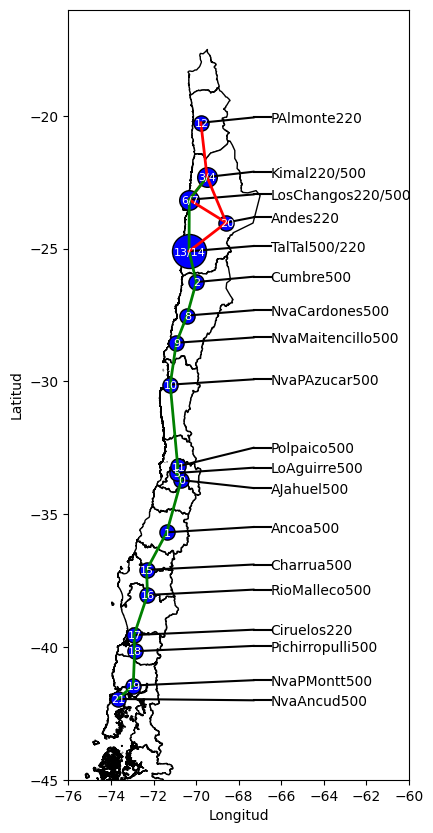

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='black')

for lat, lon in zip(df_BarrasRepresentativas['Latitud'].unique(), df_BarrasRepresentativas['Longitud'].unique()):
    df_barra = df_BarrasRepresentativas[(df_BarrasRepresentativas['Latitud'] == lat) & (df_BarrasRepresentativas['Longitud'] == lon)]
    if len(df_barra) == 1:
        Latitud = df_barra['Latitud'].values[0]
        Longitud = df_barra['Longitud'].values[0]
        Barra = df_barra['Barra'].values[0]
        Idx = df_barra['ID'].values[0]

        Longitud_Text = -66.5
        Latitud_Text = Latitud
        if Barra == 'Polpaico500':
            Latitud_Text = Latitud + 0.5
        elif Barra == 'AJahuel500':
            Latitud_Text = Latitud - 0.5
        elif Barra == 'NvaAncud500':
            Latitud_Text = Latitud - 0.25

        ax.text(Longitud_Text, Latitud_Text, Barra, fontsize=10, color='black')
        # Plot a line connecting the bar with the text
        left_margin = 0.8
        text_ymargin = 0.2
        ax.plot([Longitud, Longitud_Text-left_margin], [Latitud, Latitud_Text+text_ymargin], color='black')
        ax.plot([Longitud_Text-left_margin, Longitud_Text], [Latitud_Text+text_ymargin, Latitud_Text+text_ymargin], color='black')

        ax.scatter(Longitud, Latitud, s=120, color='blue', edgecolor='black')
        # Plot the idx of the bar
        
        if len(str(Idx)) == 1:
            ax.text(Longitud-0.15, Latitud-0.15, str(Idx), fontsize=8, color='white')
        else:
            ax.text(Longitud-0.3, Latitud-0.15, str(Idx), fontsize=8, color='white')
    else:
        Latitud = df_barra['Latitud'].values[0]
        Longitud = df_barra['Longitud'].values[0]
        Barras = df_barra['Barra'].values
        Idx = f'{df_barra["ID"].values[0]}/{df_barra["ID"].values[1]}'

        Longitud_Text = -66.5
        Latitud_Text = Latitud

        ax.text(Longitud_Text, Latitud_Text, f'{Barras[0]}/{Barras[1][-3:]}', fontsize=10, color='black')
        # Plot a line connecting the bar with the text
        left_margin = 0.8
        text_ymargin = 0.2
        ax.plot([Longitud, Longitud_Text-left_margin], [Latitud, Latitud_Text+text_ymargin], color='black')
        ax.plot([Longitud_Text-left_margin, Longitud_Text], [Latitud_Text+text_ymargin, Latitud_Text+text_ymargin], color='black')

        if len(str(Idx)) == 3:
            ax.text(Longitud-0.4, Latitud-0.15, str(Idx), fontsize=8, color='white')
            ax.scatter(Longitud, Latitud, s=200, color='blue', edgecolor='black')
        elif len(str(Idx)) == 4:
            print(Idx)
            ax.text(Longitud-0.5, Latitud-0.15, str(Idx), fontsize=8, color='white')
            ax.scatter(Longitud, Latitud, s=240, color='blue', edgecolor='black')
        elif len(str(Idx)) == 5:
            print(Idx)
            ax.text(Longitud-0.7, Latitud-0.15, str(Idx), fontsize=8, color='white')
            ax.scatter(Longitud, Latitud, s=600, color='blue', edgecolor='black')

Colores_Lineas = {220:'red', 500:'green'}
# Plot the lines between the bars in Barras_Graficadas
for idx, row in df_LineasRepresentativas.iterrows():
    Barra_from = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['From']]['Barra'].values[0]
    Barra_to = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['To']]['Barra'].values[0]
    Lat_from = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['From']]['Latitud'].values[0]
    Long_from = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['From']]['Longitud'].values[0]
    Lat_to = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['To']]['Latitud'].values[0]
    Long_to = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['To']]['Longitud'].values[0]
    Voltaje = row['Voltaje']
    if Voltaje == '500/220':
        continue
    ax.plot([Long_from, Long_to], [Lat_from, Lat_to], color=Colores_Lineas[Voltaje], linewidth=2)


x_min, x_max = df_BarrasRepresentativas['Longitud'].min(), df_BarrasRepresentativas['Longitud'].max()
y_min, y_max = df_BarrasRepresentativas['Latitud'].min(), df_BarrasRepresentativas['Latitud'].max()
ax.set_xlim(-76, -60)
ax.set_ylim(-45, -16)

ax.set_ylabel('Latitud')
ax.set_xlabel('Longitud')

plt.savefig(os.path.join(Output_dir, 'BarrasRepresentativas.svg'), dpi=1200, bbox_inches='tight', format='svg')

13/14


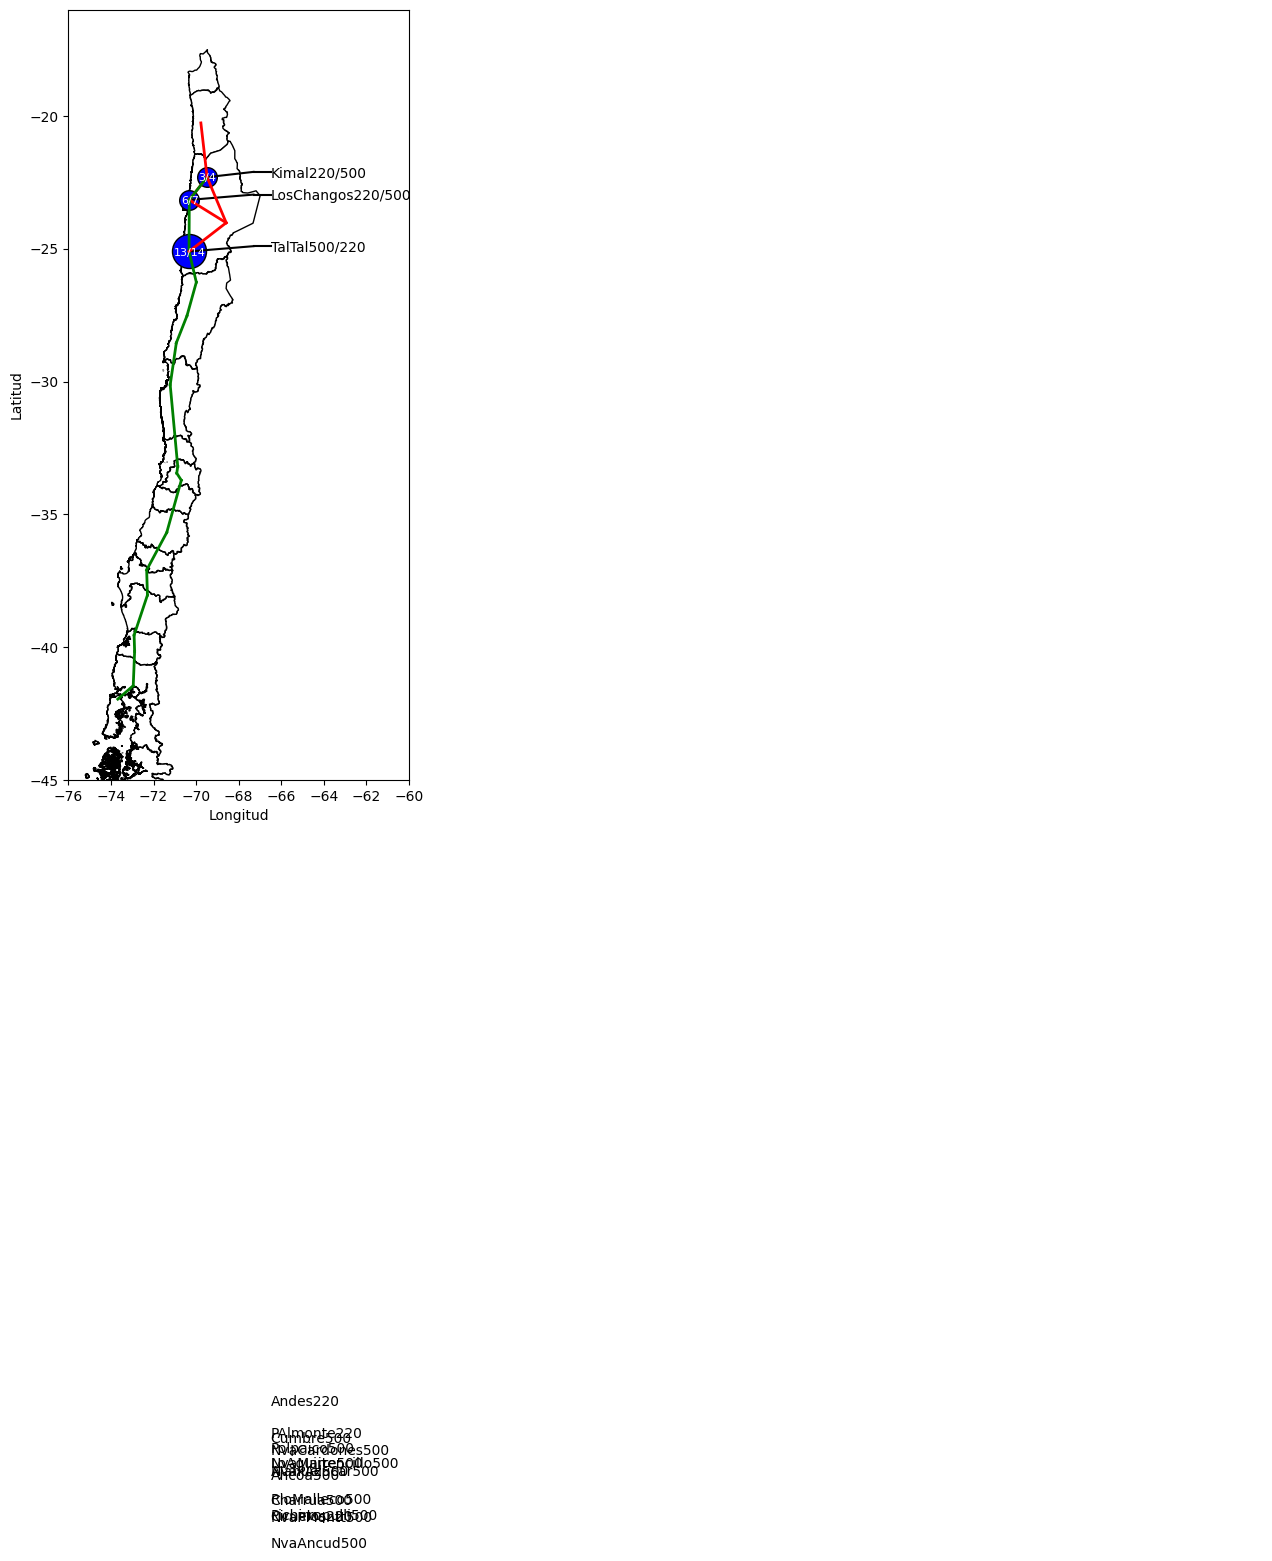

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(ax=ax, color='white', edgecolor='black')

for lat, lon in zip(df_BarrasRepresentativas['Latitud'].unique(), df_BarrasRepresentativas['Longitud'].unique()):
    df_barra = df_BarrasRepresentativas[(df_BarrasRepresentativas['Latitud'] == lat) & (df_BarrasRepresentativas['Longitud'] == lon)]
    if len(df_barra) == 1:
        Longitud = df_barra['Latitud'].values[0]
        Latitud = df_barra['Longitud'].values[0]
        Barra = df_barra['Barra'].values[0]
        Idx = df_barra['ID'].values[0]

        Longitud_Text = -66.5
        Latitud_Text = Latitud
        if Barra == 'Polpaico500':
            Latitud_Text = Latitud + 0.5
        elif Barra == 'AJahuel500':
            Latitud_Text = Latitud - 0.5
        elif Barra == 'NvaAncud500':
            Latitud_Text = Latitud - 0.25

        ax.text(Longitud_Text, Latitud_Text, Barra, fontsize=10, color='black')
        # Plot a line connecting the bar with the text
        left_margin = 0.8
        text_ymargin = 0.2
        ax.plot([Longitud, Longitud_Text-left_margin], [Latitud, Latitud_Text+text_ymargin], color='black')
        ax.plot([Longitud_Text-left_margin, Longitud_Text], [Latitud_Text+text_ymargin, Latitud_Text+text_ymargin], color='black')

        ax.scatter(Longitud, Latitud, s=120, color='blue', edgecolor='black')
        # Plot the idx of the bar
        
        if len(str(Idx)) == 1:
            ax.text(Longitud-0.15, Latitud-0.15, str(Idx), fontsize=8, color='white')
        else:
            ax.text(Longitud-0.3, Latitud-0.15, str(Idx), fontsize=8, color='white')
    else:
        Latitud = df_barra['Latitud'].values[0]
        Longitud = df_barra['Longitud'].values[0]
        Barras = df_barra['Barra'].values
        Idx = f'{df_barra["ID"].values[0]}/{df_barra["ID"].values[1]}'

        Longitud_Text = -66.5
        Latitud_Text = Latitud

        ax.text(Longitud_Text, Latitud_Text, f'{Barras[0]}/{Barras[1][-3:]}', fontsize=10, color='black')
        # Plot a line connecting the bar with the text
        left_margin = 0.8
        text_ymargin = 0.2
        ax.plot([Longitud, Longitud_Text-left_margin], [Latitud, Latitud_Text+text_ymargin], color='black')
        ax.plot([Longitud_Text-left_margin, Longitud_Text], [Latitud_Text+text_ymargin, Latitud_Text+text_ymargin], color='black')

        if len(str(Idx)) == 3:
            ax.text(Longitud-0.4, Latitud-0.15, str(Idx), fontsize=8, color='white')
            ax.scatter(Longitud, Latitud, s=200, color='blue', edgecolor='black')
        elif len(str(Idx)) == 4:
            print(Idx)
            ax.text(Longitud-0.5, Latitud-0.15, str(Idx), fontsize=8, color='white')
            ax.scatter(Longitud, Latitud, s=240, color='blue', edgecolor='black')
        elif len(str(Idx)) == 5:
            print(Idx)
            ax.text(Longitud-0.7, Latitud-0.15, str(Idx), fontsize=8, color='white')
            ax.scatter(Longitud, Latitud, s=600, color='blue', edgecolor='black')

Colores_Lineas = {220:'red', 500:'green'}
# Plot the lines between the bars in Barras_Graficadas
for idx, row in df_LineasRepresentativas.iterrows():
    Barra_from = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['From']]['Barra'].values[0]
    Barra_to = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['To']]['Barra'].values[0]
    Lat_from = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['From']]['Latitud'].values[0]
    Long_from = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['From']]['Longitud'].values[0]
    Lat_to = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['To']]['Latitud'].values[0]
    Long_to = df_BarrasRepresentativas[df_BarrasRepresentativas['ID'] == row['To']]['Longitud'].values[0]
    Voltaje = row['Voltaje']
    if Voltaje == '500/220':
        continue
    ax.plot([Long_from, Long_to], [Lat_from, Lat_to], color=Colores_Lineas[Voltaje], linewidth=2)


x_min, x_max = df_BarrasRepresentativas['Longitud'].min(), df_BarrasRepresentativas['Longitud'].max()
y_min, y_max = df_BarrasRepresentativas['Latitud'].min(), df_BarrasRepresentativas['Latitud'].max()
ax.set_xlim(-76, -60)
ax.set_ylim(-45, -16)

ax.set_ylabel('Latitud')
ax.set_xlabel('Longitud')

plt.savefig(os.path.join(Output_dir, 'BarrasRepresentativas_lat.png'), dpi=300, bbox_inches='tight')